## 1. Import requirements

In [1]:
import os
import sys
import pandas as pd
import matplotlib.pyplot as plt
import tqdm
import torch
from torch.utils.data import DataLoader

In [2]:
from rdkit import Chem, DataStructs
from rdkit.Chem import AllChem, Draw, rdFMCS, Descriptors
from rdkit.Chem.Draw import IPythonConsole
IPythonConsole.molSize = 250,250

In [3]:
sys.path = [os.path.abspath(os.path.join(os.getcwd(), os.pardir))] + sys.path

In [4]:
from COMA.dataset import ValidationSmilesDataset
from COMA.vae import SmilesAutoencoder
from COMA.properties import qed, similarity

## 2. Configure GPU

In [5]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")
print(device)

cuda:0


## 3. Specify a target property

In [6]:
PROPERTY_NAME = "qed"
SCORING_FT = qed

## 4. Set directories (for inputs and outputs)

In [7]:
input_data_dir = os.path.abspath(os.path.join(os.pardir, "DATA", PROPERTY_NAME))
input_ckpt_dir = f"outputs_2-2_{PROPERTY_NAME.upper()}_finetuning"

In [8]:
output_dir = "outputs_2-6_QED_drawing_molecules"
if not os.path.exists(output_dir):
    os.mkdir(output_dir)

## 5. Set filenames

In [9]:
filepath_src = os.path.join(input_data_dir, "rdkit_train_src.txt")

In [10]:
filepath_pretrain_ckpt     = os.path.join(input_ckpt_dir, "checkpoints.pt")
filepath_pretrain_configs  = os.path.join(input_ckpt_dir, "configs.csv")
filepath_pretrain_char2idx = os.path.join(input_ckpt_dir, "char2idx.csv")

## 6. Load datasets

In [11]:
dataset_src = ValidationSmilesDataset(filepath_src, filepath_pretrain_char2idx, device=device)

## 7. Load a pretrained model

In [12]:
## Model configuration
model_configs = {"hidden_size"    :None,
                 "latent_size"    :None,
                 "num_layers"     :None,
                 "vocab_size"     :None,
                 "sos_idx"        :None,
                 "eos_idx"        :None,
                 "pad_idx"        :None,
                 "device"         :device,
                 "filepath_config":filepath_pretrain_configs}

## Model initialization
generator = SmilesAutoencoder(**model_configs)

## Load pretrained model
generator.load_model(filepath_pretrain_ckpt)

In [13]:
K = 10 # repetition count of translation

frames = []

for batch in tqdm.tqdm(DataLoader(dataset_src, batch_size=1, shuffle=False, drop_last=False, pin_memory=use_cuda)):
    
    batch_smiles = dataset_src.encode(batch["smiles_s"], batch["length_s"].max())
    batch_length = batch["length_s"]
    smi_src = batch["smiles_s"][0][1:-1]
    
    ## translation
    succeeded = set()
    
    for _ in range(100):
        seq = generator.predict(batch_smiles, batch_length)
        smi_tar = dataset_src.decode(seq)[0] # assumption: batch_size=1
        
        if Chem.MolFromSmiles(smi_tar) is not None:
            sim = similarity(smi_src, smi_tar)
            prop = SCORING_FT(smi_tar)
            if sim > 0.4 and prop > 0.9:
                succeeded.add((smi_src, smi_tar, sim, prop))
        
        if len(succeeded) == K:
            break
            
    if len(succeeded) == K:
        generated = list(succeeded)
        df_generated = pd.DataFrame.from_records(generated)
        df_generated = df_generated.rename(columns={0:'source', 1:'target', 2:'TANIMOTO', 3:'PROPERTY'})
        frames.append(df_generated)
        if len(frames) == 2:
            break       

  0%|          | 48/88306 [01:13<37:29:32,  1.53s/it]


In [14]:
frames[0]

,source,target,TANIMOTO,PROPERTY
0,CC1=CC=C(C(=O)N2CC(C(=O)[O-])CC(C(=O)N3CCOCC3)...,CC1=CC=C(C(=O)N2CC(C(=O)NCC3=CC=CS3)CC2)C=C1F,0.442857,0.925224
1,CC1=CC=C(C(=O)N2CC(C(=O)[O-])CC(C(=O)N3CCOCC3)...,CC1=CC=C(C(=O)N2CC(C(=O)NCC3CCCC3)CC2)C=C1F,0.454545,0.921546
2,CC1=CC=C(C(=O)N2CC(C(=O)[O-])CC(C(=O)N3CCOCC3)...,CC1=CC=C(C(=O)N2CC(C(=O)NCC3=CC=C(F)C=C3)CC2)C...,0.447761,0.913285
3,CC1=CC=C(C(=O)N2CC(C(=O)[O-])CC(C(=O)N3CCOCC3)...,CC1=CC=C(C(=O)N2CC(C(=O)NC3CCOCC3)CC2)C=C1F,0.548387,0.918299
4,CC1=CC=C(C(=O)N2CC(C(=O)[O-])CC(C(=O)N3CCOCC3)...,CC1=CC=C(C(=O)N2CC(C(=O)NC3=CC=C(F)C=C3)CC2)C=C1F,0.468750,0.928003
5,CC1=CC=C(C(=O)N2CC(C(=O)[O-])CC(C(=O)N3CCOCC3)...,CC1=CC=C(C(=O)N2CC(C(=O)NCC3=CC=CC=C3)CC2)C=C1F,0.447761,0.930302
6,CC1=CC=C(C(=O)N2CC(C(=O)[O-])CC(C(=O)N3CCOCC3)...,CC1=CC=C(C(=O)N2CC(C(=O)NCC3CCOCC3)CC2)C=C1F,0.523077,0.906916
7,CC1=CC=C(C(=O)N2CC(C(=O)[O-])CC(C(=O)N3CCOCC3)...,CC1=CC=C(C(=O)N2CC(C(=O)NC3CCCC3)CC2)C=C1F,0.476190,0.931283
8,CC1=CC=C(C(=O)N2CC(C(=O)[O-])CC(C(=O)N3CCOCC3)...,CC1=CC=C(C(=O)N2CC(C(=O)NC(C)C)CC2)C=C1F,0.483871,0.927457
9,CC1=CC=C(C(=O)N2CC(C(=O)[O-])CC(C(=O)N3CCOCC3)...,CC1=CC=C(C(=O)N2CC(C(=O)NCC3CCOC3)CC2)C=C1F,0.485294,0.912553


In [15]:
def draw_molecule(df, filepath=None):
    
    n_row, n_col = 3, 4
    
    fig, ax = plt.subplots(n_row, n_col, figsize=(4*n_col, 4*n_row))
    
    for x in range(n_row):
        for y in range(n_col):
            ax[x,y].axis('off')
    
    # src
    smi_src = df.iloc[0,0]
    mol_src = Chem.MolFromSmiles(smi_src)
    ax[0,0].imshow(Draw.MolToImage(mol_src, size=(1000,1000)))
    ax[0,0].set_title('Source')
    
    # tar
    n_tar = min(n_row * (n_col-1), len(df))
    for i in range(n_tar):
        x, y = i // (n_col-1), i % (n_col-1) + 1
        smi_tar = df.iloc[i,1]
        mol_tar = Chem.MolFromSmiles(smi_tar)
        ax[x,y].imshow(Draw.MolToImage(mol_tar, size=(1000,1000)))
        ax[x,y].set_title(f'Tanimoto:{df.iloc[i,2]:.3f}\nProperty:{df.iloc[i,3]:.3f}')

    plt.tight_layout()
    if filepath:
        plt.savefig(filepath, dpi=300)
    plt.show()

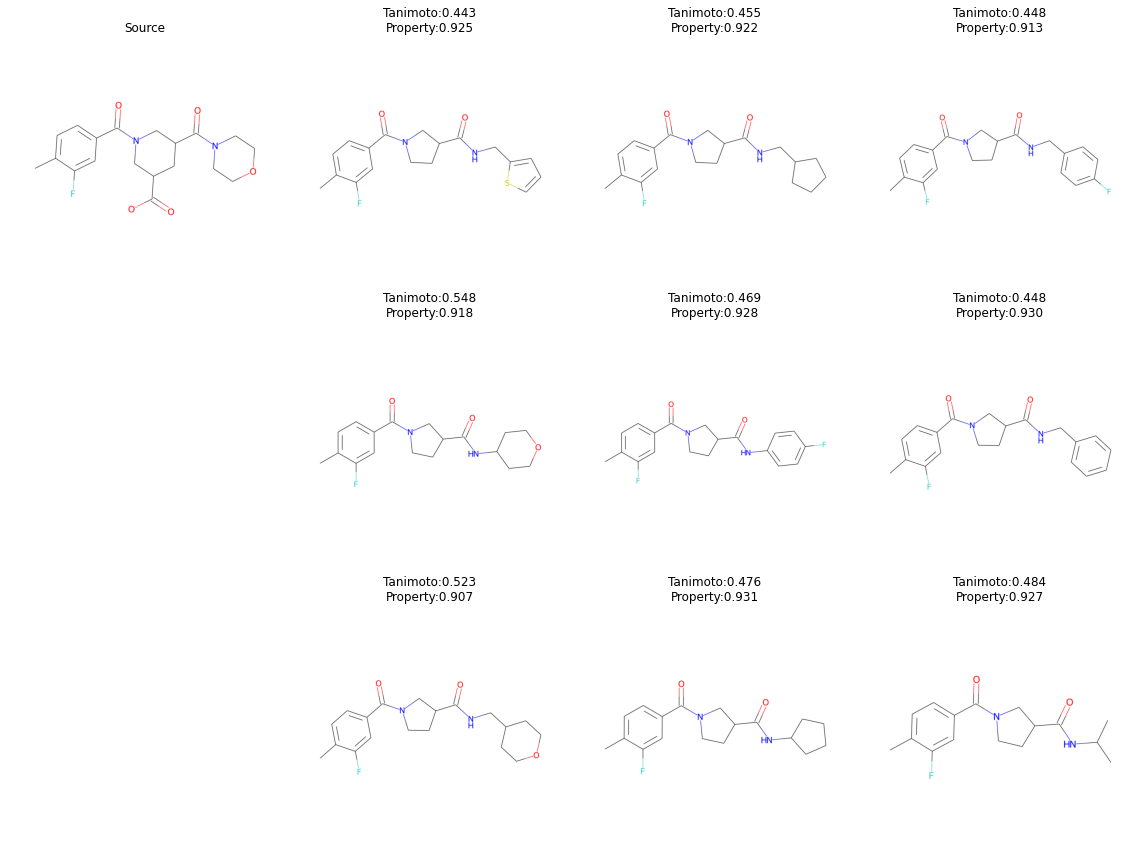

In [16]:
draw_molecule(frames[0], os.path.join(output_dir, "example_0.png"))

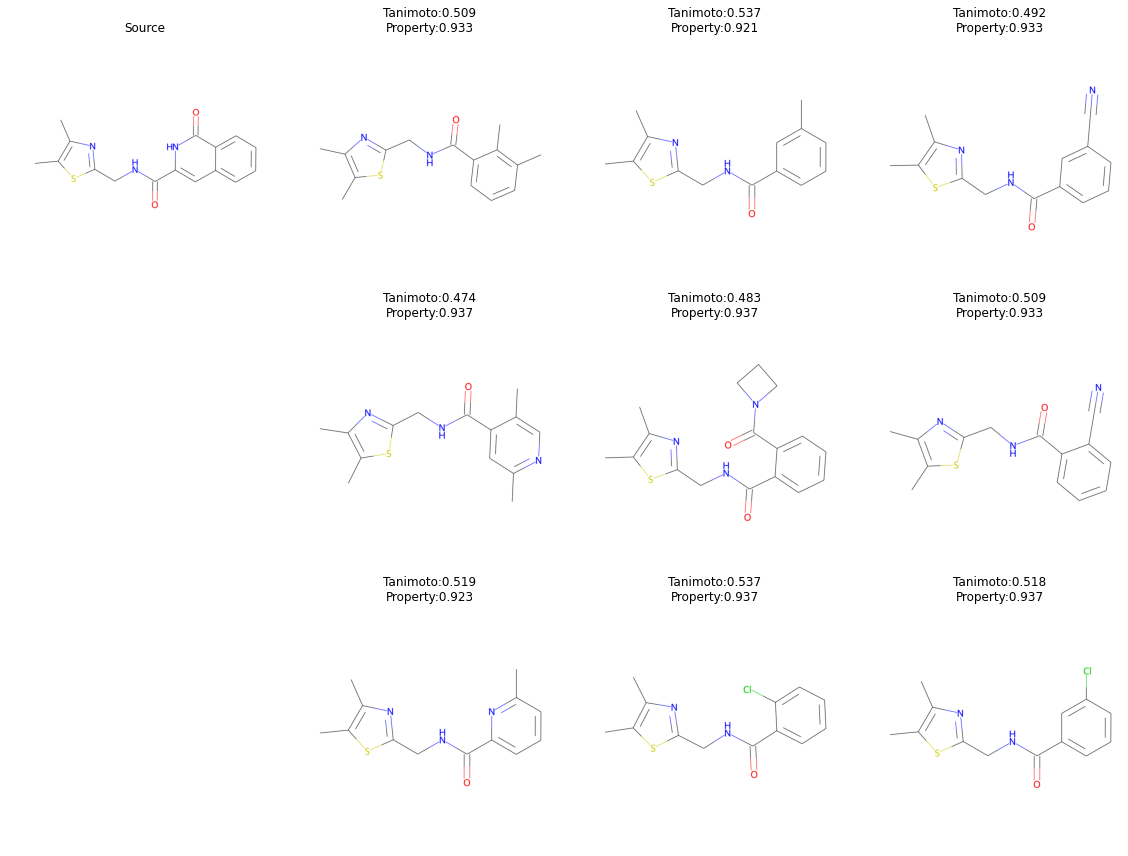

In [17]:
draw_molecule(frames[1], os.path.join(output_dir, "example_1.png"))